## 22 Time Series

In [45]:
# Importación de librerías
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y herramientas de machine learning
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from sklearn.metrics import mean_squared_error

# Modelos estadísticos y herramientas
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA  # Uso del módulo actualizado
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Corrige el nombre

# Configuración de logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [5]:
df_raw= sns.load_dataset('flights')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [6]:
df_raw.sample(10,random_state=2025)

,year,month,passengers
2,1949,Mar,132
82,1955,Nov,237
77,1955,Jun,315
26,1951,Mar,178
23,1950,Dec,140
44,1952,Sep,209
54,1953,Jul,264
0,1949,Jan,112
5,1949,Jun,135
108,1958,Jan,340


In [16]:
# Crear una copia del DataFrame original para no modificar los datos originales directamente
df_baking = df_raw.copy()

# Convertir la columna 'month' de un formato abreviado (como 'Jan', 'Feb') a un formato numérico (1, 2, ... 12)
df_baking['month'] = pd.to_datetime(df_baking['month'], format='%b').dt.month

# Crear una nueva columna 'date' convirtiendo las columnas 'year' y 'month' en un objeto de tipo datetime.
# Se asigna un valor fijo de 'day=1' para que todas las fechas correspondan al primer día del mes.
df_baking['date'] = pd.to_datetime(df_baking[['year', 'month']].assign(day=1))

# Establecer la columna 'date' como el índice del DataFrame para facilitar análisis basados en series de tiempo
df_baking = df_baking.set_index('date')

# Mostrar el DataFrame resultante (opcional, muestra el contenido de df_baking en el entorno de ejecución)
df_baking


,year,month,passengers
date,,,
1949-01-01,1949,1,112
1949-02-01,1949,2,118
1949-03-01,1949,3,132
1949-04-01,1949,4,129
1949-05-01,1949,5,121
...,...,...,...
1960-08-01,1960,8,606
1960-09-01,1960,9,508
1960-10-01,1960,10,461


In [17]:
# Eliminar columnas 'year' y 'month'
df_baking = df_baking.drop(columns=['year', 'month'])

# Crear una copia para evitar modificar el original
df = df_baking.copy()

# Mostrar información estructural del DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2 EDA

In [ ]:
# Seleccionar todas las filas excepto las últimas 12 para crear el conjunto de entrenamiento
df_train = df.iloc[:-12, :]

# Seleccionar las últimas 12 filas para crear el conjunto de prueba
df_test = df.iloc[-12:, :]

# Mostrar el conjunto de entrenamiento (opcional para verificar su contenido)
df_train

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


In [19]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,132.0,262.492424,106.625799,104.0,176.5,239.5,343.25,559.0


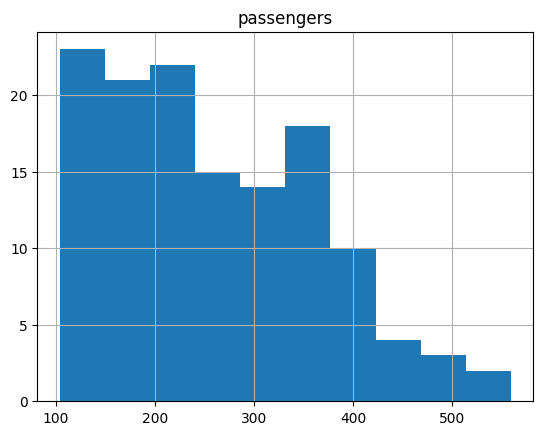

In [20]:
df_train.hist()
plt.show()

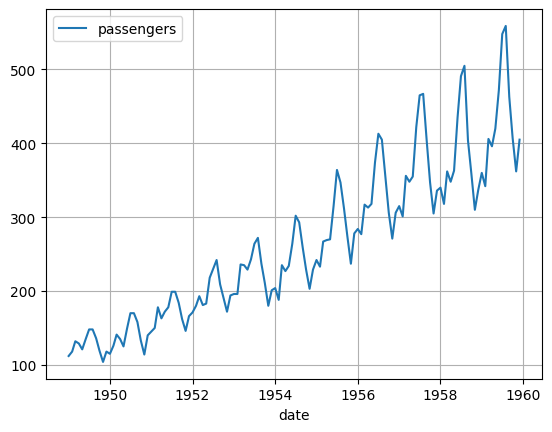

In [25]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

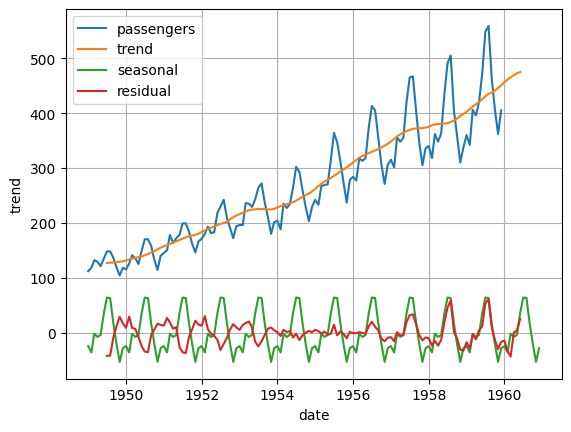

In [28]:
decomspsition = seasonal_decompose(df['passengers'],period=12)
trend = decomspsition.trend
seasonal = decomspsition.seasonal
residual = decomspsition.resid
sns.lineplot(df_train)
sns.lineplot(trend,label='trend')
sns.lineplot(seasonal, label='seasonal')
sns.lineplot(residual, label='residual')
plt.grid(True)
plt.show()

### d = orden de diferencia = estacionalidad; hay que  quitar ese ruido si es necesario 
p = 

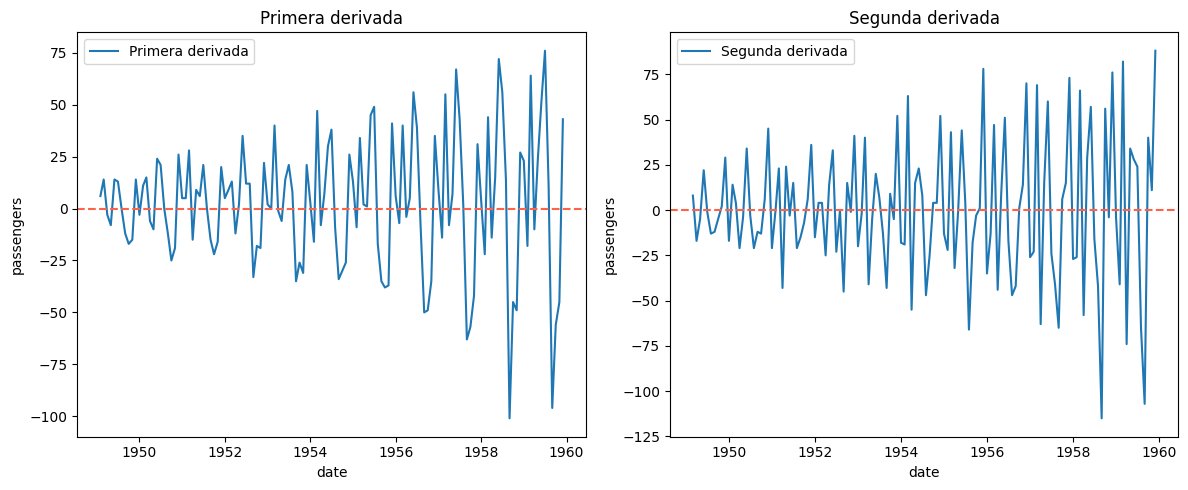

In [37]:
# d = estacionariedad, cuando los puntos de datos no tienen tendencia
# Así se elimina la estacionalidad aplicando diferenciación

# Crear una figura con 2 subgráficos (1 fila, 2 columnas)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Subplots estaba mal, debe ser subplots

# Graficar la primera derivada (diferenciación de primer orden)
sns.lineplot(x=df_train.index, y=df_train['passengers'].diff(), label='Primera derivada', ax=ax[0])
ax[0].axhline(0, color='tomato', linestyle='--')  # Línea horizontal en 0
ax[0].set_title('Primera derivada')

# Graficar la segunda derivada (diferenciación de segundo orden)
sns.lineplot(x=df_train.index, y=df_train['passengers'].diff().diff(), label='Segunda derivada', ax=ax[1])
ax[1].axhline(0, color='tomato', linestyle='--')  # Línea horizontal en 0
ax[1].set_title('Segunda derivada')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el espacio entre gráficos
plt.show()


In [34]:
#alfa como nivel de significancia = 0.05
#si el pvalue < alfa, Estacionario = No tiene Trend
#si pvalue > alfa, No es Estacionario = Si tiene Trend
ad_fuller = adfuller(df_train)
print(f'adf statistic= {ad_fuller[0]:.2f}')
print(f'pvalue= {ad_fuller[1]:.2f}')

adf statistic= 0.89
pvalue= 0.99


In [ ]:
#alfa esta muy alto hay que bajarlo con derivada 
#si el pvalue < alfa, Estacionario = No tiene Trend
#si pvalue > alfa, No es Estacionario = Si tiene Trend
ad_fuller = adfuller(df_train['passengers'].diff().dropna())
print(f'adf statistic= {ad_fuller[0]:.2f}')
print(f'pvalue= {ad_fuller[1]:.2f}')

adf statistic= -2.40
pvalue= 0.14


In [38]:
ad_fuller = adfuller(df_train['passengers'].diff().diff().dropna())
print(f'adf statistic= {ad_fuller[0]:.2f}')
print(f'pvalue= {ad_fuller[1]:.2f}')

adf statistic= -14.25
pvalue= 0.00


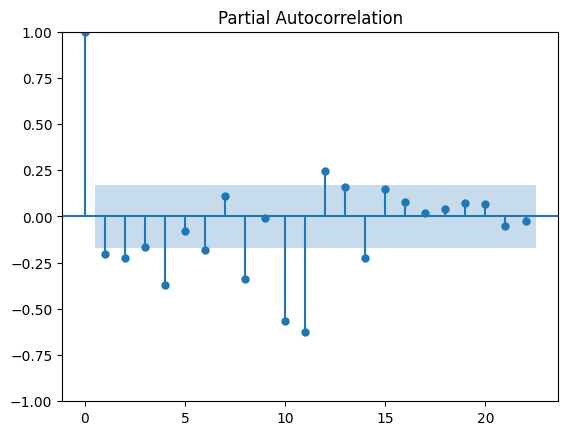

In [ ]:
# pvalue lo que calcula con la regresion parcial es el termino autoregresivo
# autoregresivo significa Seasonality
# Graficar la función de autocorrelación parcial (PACF) para la segunda diferencia del conjunto de entrenamiento
#p = partial autocorr
plot_pacf(df_train.diff().diff().dropna())
plt.show()


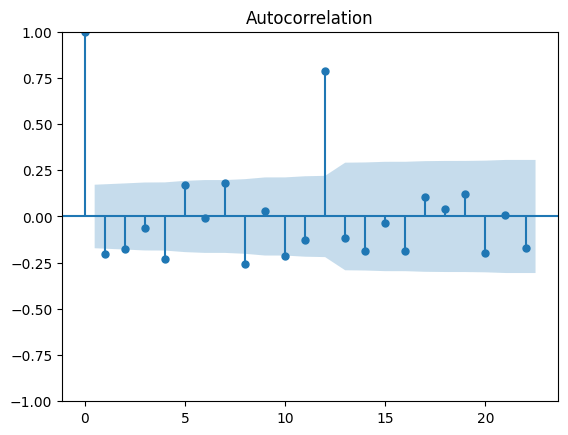

In [ ]:
# calcular temrino q
# q = promedio movil 
# lo hacemos con un grafico de la Autocorrelacion ACF
plot_acf(df_train.diff().diff().dropna())
plt.show()

## Machine learning

In [48]:
#order=(d,p,q)
# d=diff()
# p= partial autocorrel
# q= moving average
ts_arima = ARIMA(df['passengers'],order=(2,1,1))
ts_arima = ts_arima.fit()
print(ts_arima.summary())


/workspaces/4GEEKS_CLASSES/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Thu, 06 Mar 2025   AIC                           1378.338
Time:                        03:34:10   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

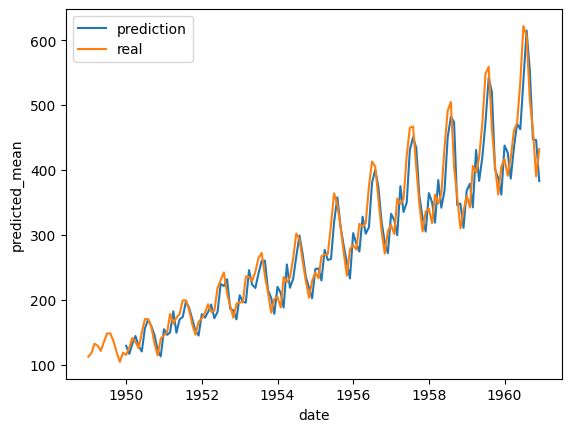

In [50]:
#predict(cuantos puntos hacia adelante?)
y_hat = ts_arima.predict(12)
y_hat
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['passengers'], label='real')
plt.show()